# E-commerce — Анализ товарного ассортимента

***Описание проекта и его цели:*** 

В этом проекте мы будем анализировать ассортимент магазина, продающего товары для дома и сада. Для начала нам нужно привести данные в удобный вид: очистить их от пропусков и дубликатов, изменить в нескольких столбцах тип данных и добавить новые столбцы.

Затем мы перейдем к исследованию ассортимента и продаж. Посмотрим динамику продаж по месяцам, дням и часам. С помощью АВС-анализа выделим основнойи дополнительный ассортимент и построим графики продаж этих двух групп также по месяцам и дням. Также мы выделим 5-7 категорий товаров. После этого будет проведем статистический анализ, где мы проверим несколько гипотез. 

## Декомпозиция проекта

**1. Предобработка данных:**

    - удаление явных и неявных дубликатов;
    - проверка наличия пропусков;
    - проверка выбросов и ошибок -> удаление или исправление;

**2. Изучение данных по графикам:**

    - АВС 2х анализ для разделения товаров на категории и
    выявление основных и дополнительных товаров. Анализ по выручке и по количеству проданных единиц;

    - гистограммы по месяцам, дням недели и часам -> выводы по этим временным промежуткам;

**3. Формулировка гипотез:**

    - сами гипотезы;

    - определение методов проверки;

    - расчеты;

    - выводы по результатам проверки;

**4. Общий вывод**

**5. Создание презентации**

### Презентация по проекту:

https://drive.google.com/file/d/1rqrYUjD7lekd87Z5gjPL2wnmF7jXQbS5/view?usp=sharing

## Предобработка данных

In [1]:
pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import plotly
import plotly.express as px
import scipy
from scipy import stats as st
import plotly.graph_objects as go
import re
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter
import itertools
from itertools import cycle
from plotly.subplots import make_subplots

In [3]:
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.5

In [4]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTarzENgEfTwYSarjZZcZCoezlJzHve0d-oByjIyXqksd-WCLd4KbQOfbm8l3GPfUBMVucMawamp1Nn/pub?output=csv')
print(data.head())
print(data.info())

         date                           customer_id  order_id  \
0  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  
0    Комнатное растение в горшке Алое Вера, d12, h30         1  142.0  
1  Комнатное растение в горшке Кофе Арабика, d12,...         1  194.0  
2                        Радермахера d-12 см h-20 см         1  112.0  
3                   Хризолидокарпус Лутесценс d-9 см         1  179.0  
4                     Циперус Зумула d-12 см h-25 см         1  112.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       -----------

In [5]:
# изменяем типы данных 
data['price'] = data['price'].astype("int64")
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')
print(data['date'].head())

0   2018-10-01
1   2018-10-01
2   2018-10-01
3   2018-10-01
4   2018-10-01
Name: date, dtype: datetime64[ns]


In [6]:
# поиск явных дубликатов
print(data.duplicated().sum())

0


Для поиска неявных дубликатов, сгруппируем базу по заказам.
Если у одного заказа несколько пользователей, эти данные нужно удалить

In [7]:
order_customer_dublicates_df = data.pivot_table(index='order_id',
                                                values='customer_id',
                                                aggfunc='nunique').sort_values(by='customer_id',
                                                                               ascending=False).reset_index()
print(order_customer_dublicates_df.query('customer_id > 1'))

    order_id  customer_id
0      72845            4
1      71480            3
2      69485            3
3      69410            2
4      71226            2
5      69283            2
6      72950            2
7      70631            2
8      69531            2
9      69833            2
10     70946            2
11     70808            2
12     71054            2
13     69345            2
14     72778            2
15     72188            2
16     71542            2
17     68785            2
18     69310            2
19     71571            2
20     72790            2
21     70114            2
22     14872            2
23     71663            2
24     70726            2
25     71461            2
26     70903            2
27     70542            2
28     71648            2


Теперь мы знаем id заказов, у которых несколько покупателей. Почему так произошло непонятно, возможно был какой-то сбой. 
Столбец order_id мы сделаем списком, передадим его как аргумент функции drop_dublicates()и удалим эти идентификаторы из базы данных.

In [8]:
orders_dublicates_df = order_customer_dublicates_df['order_id'].head(29).to_list()
order_customer_dublicates_df = order_customer_dublicates_df[order_customer_dublicates_df.order_id.isin(orders_dublicates_df) == False]
print(order_customer_dublicates_df.query('customer_id > 1'))  # проверка работы кода

Empty DataFrame
Columns: [order_id, customer_id]
Index: []


In [9]:
data = data[data.order_id.isin(orders_dublicates_df) == False]

In [10]:
data.duplicated(subset=['order_id', 'customer_id', 'product']).sum()

1863

In [11]:
data = data.drop_duplicates(subset=['order_id', 'customer_id', 'product'], keep='last').reset_index(drop=True)
print(data.duplicated(subset=['order_id', 'customer_id', 'product']).sum())
print(data.info())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5522 entries, 0 to 5521
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5522 non-null   datetime64[ns]
 1   customer_id  5522 non-null   object        
 2   order_id     5522 non-null   int64         
 3   product      5522 non-null   object        
 4   quantity     5522 non-null   int64         
 5   price        5522 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 259.0+ KB
None


Проверим есть ли выбросы в столбцах с количеством товара и ценой

In [12]:
print(data['quantity'].describe())
print(' ')
print(data['price'].describe())

count    5522.000000
mean        2.579500
std        16.505923
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64
 
count     5522.000000
mean       531.605759
std        975.252354
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64


date           92
customer_id    92
order_id       92
product        92
quantity       92
price          92
dtype: int64


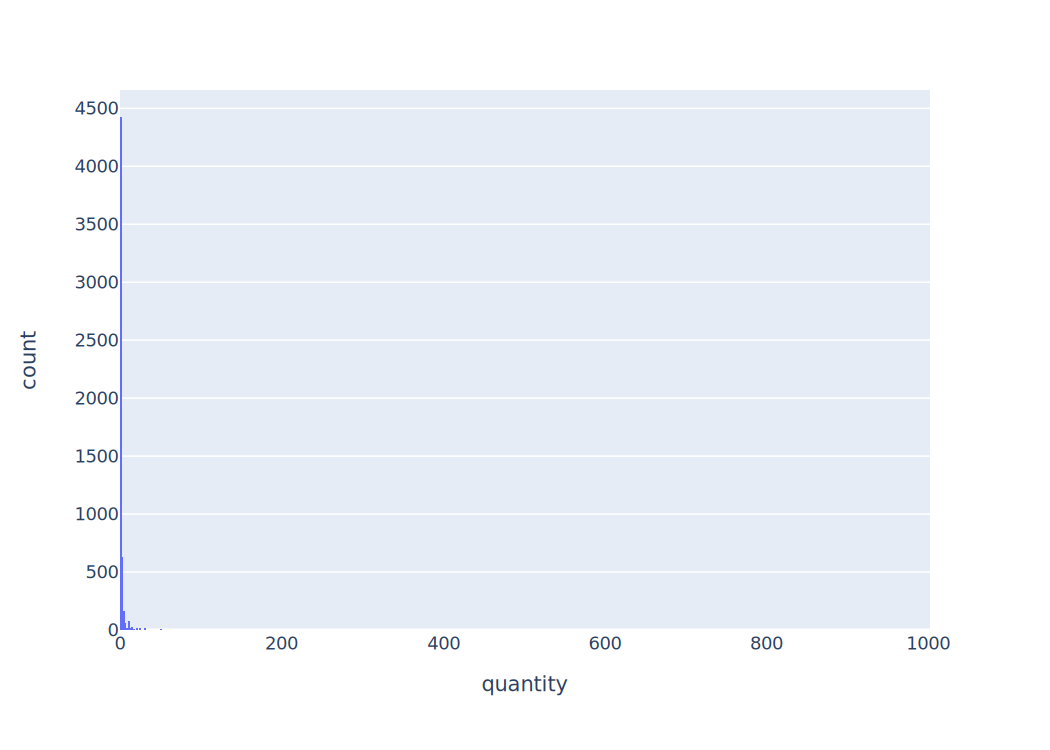

In [13]:
print(data.query('quantity >= 20').count())

fig =  px.histogram(data, x="quantity")
fig.show()

Выбросы помешают нам правильно разделить товар на основной и дополнительный, поэтому мы удалим заказы с количеством товара больше 20.

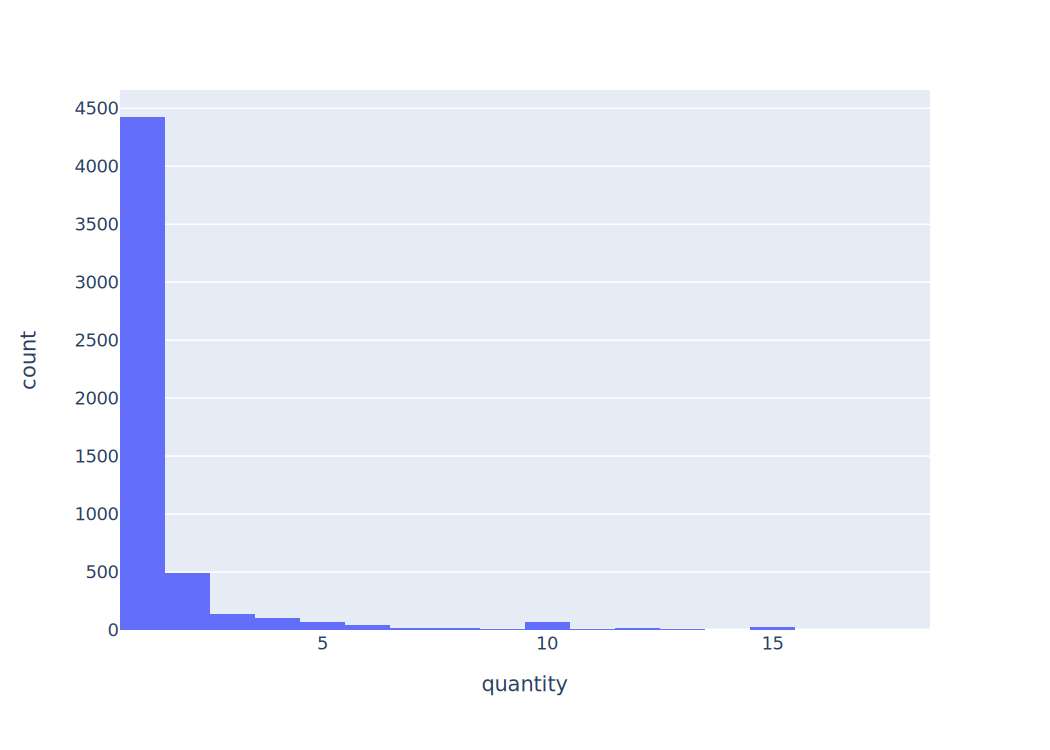

date           374
customer_id    374
order_id       374
product        374
quantity       374
price          374
dtype: int64


In [14]:
data = data.query('quantity < 20')

fig =  px.histogram(data, x="quantity")
fig.show()
print(data.query('quantity > 3').count())

в столбце 'product' некоторые название указаны в кавычках, удалим их, чтобы было легче работать с данными

In [15]:
data['product'] = data['product'].str.replace('"', '')
data['product'] = data['product'].str.lower()
print(f'Всего {data["product"].nunique()} наименований товара.', 
      f'\n Было продано {data["quantity"].sum()} единиц товара')

Всего 2300 наименований товара. 
 Было продано 8573 единиц товара


In [16]:
data['revenue'] = data['quantity'] * data['price']

Создаем столбцы с годом, месяцем, днем недели и часом, когда был зарегистрирован заказ.

In [17]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month_name()
data['day'] = data['date'].dt.day_name()
data['hour'] = data['date'].dt.hour

***Вывод по разделу "Предобработка данных":***

Изначально в датасете было 7474 строк. Явных дубликатов обнаружено не было, но в данных присутствовало множество неявных дубликатов, где отличалось только время заказа, возможно в таблицу заносился каждый шаг покупки. Поэтому мы оставили только последние записи.Также были обнаружены одинаковые id заказов с несколькими покупателями, в этом случае мы удалили все подобные записи. В итоге в датасете осталось 5522 строк.

Был добавлен столбец с выручкой от проданных товаров, который понадобиться нам позже для выделения основного и дополнительного ассортимента, и столбцы с годом, месяцем, названием дня недели и часом, когда был сделан заказ. 

## Исследовательский анализ данных

In [18]:
print(data['product'].value_counts().head(30))

product
пеларгония розебудная red pandora укорененный черенок                                                      65
пеларгония розебудная prins nikolai укорененный черенок                                                    54
пеларгония зональная диам. 12 см сиреневый полумахровый                                                    53
сумка-тележка 2-х колесная gimi argo синяя                                                                 47
пеларгония розебудная mary укорененный черенок                                                             40
пеларгония розебудная queen ingrid укорененный черенок                                                     31
пеларгония розебудная margaretha укорененный черенок                                                       31
пеларгония зональная ринго вайт d-7 см h-10 см укорененный черенок                                         25
пеларгония зональная махровая лососевая                                                                    25
пе

В ТОП 30 наиболее покупаемых товаров 18 раз входят различные сорта Пеларгонии. 

Построим графики, чтобы понять, сколько заказов было совершено в каждый год/месяц/день/час

In [19]:
month_orders = data.pivot_table(index=['year', 'month'],
                                values='order_id',
                                aggfunc='nunique').reset_index()

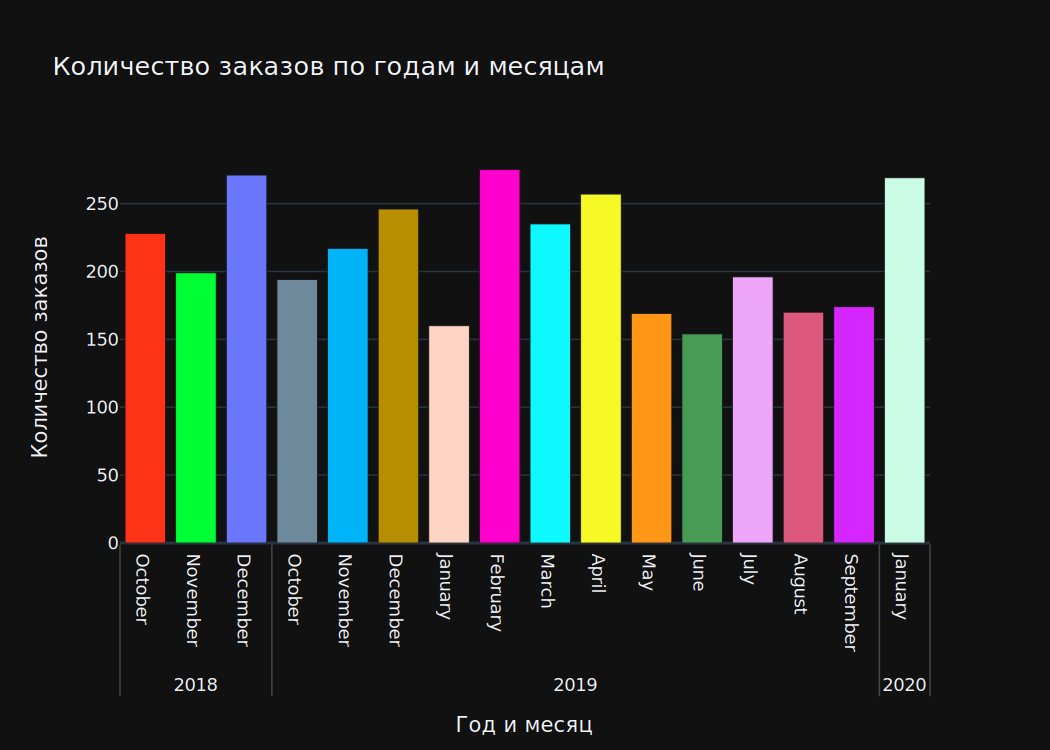

In [20]:
months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

month_orders['month'] = pd.Categorical(month_orders['month'],
                                       categories=months,
                                       ordered=True)
month_orders = month_orders.sort_values(by=['year', 'month']).reset_index(drop=True)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Bar(x=[month_orders['year'], month_orders['month']],
                     y=month_orders['order_id'], marker=dict(color=px.colors.qualitative.Light24)), row=1, col=1)
fig.update_layout(title_text='Количество заказов по годам и месяцам',
                  xaxis_title='Год и месяц',
                  yaxis_title='Количество заказов',
                  template='plotly_dark'
                  )
fig.show()

На графике мы видим, чтобы данных за 2018 и 2020 годы довольно мало, а 2019 учтены все 12 месяцев. Так как за два года у нас не хватает большей части данных, то динамику по годам сравнить не получится. Плавный спад числа заказов с октября (700 покупок) по январь (450 покупок). Скорее всего, октябрь, ноябрь и декабрь выделяются числом заказов из-за того, что есть данных и за 2018 и за 2019 годы. Поэтому мы не можем сравнить их показатели на данном графике с высокими показателями апреля и мая. В феврале и марте было сделано мало заказов - 350 и чуть больше 400 соответственно. В апреле и мае мы видим скачок до 650 и 680. В июне и июле было чуть больше 300 покупок в каждом месяце. Самые низкие значения в августе и сентябре 200 и 210 примерно

In [21]:
day_orders = data.pivot_table(index='day',
                              values='order_id',
                              aggfunc='nunique').reset_index()

In [22]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_orders['day'] = pd.Categorical(day_orders['day'],
                                   categories=days,
                                   ordered=True)
day_orders = day_orders.sort_values(by='day').reset_index(drop=True)
fig = px.bar(day_orders,
             x='day',
             y='order_id',
             color='day',
             title='Количество заказов по дням',
             template='plotly_dark')

C:\ProgramData\anaconda3\Lib\site-packages\plotly\express\_core.py:1958: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



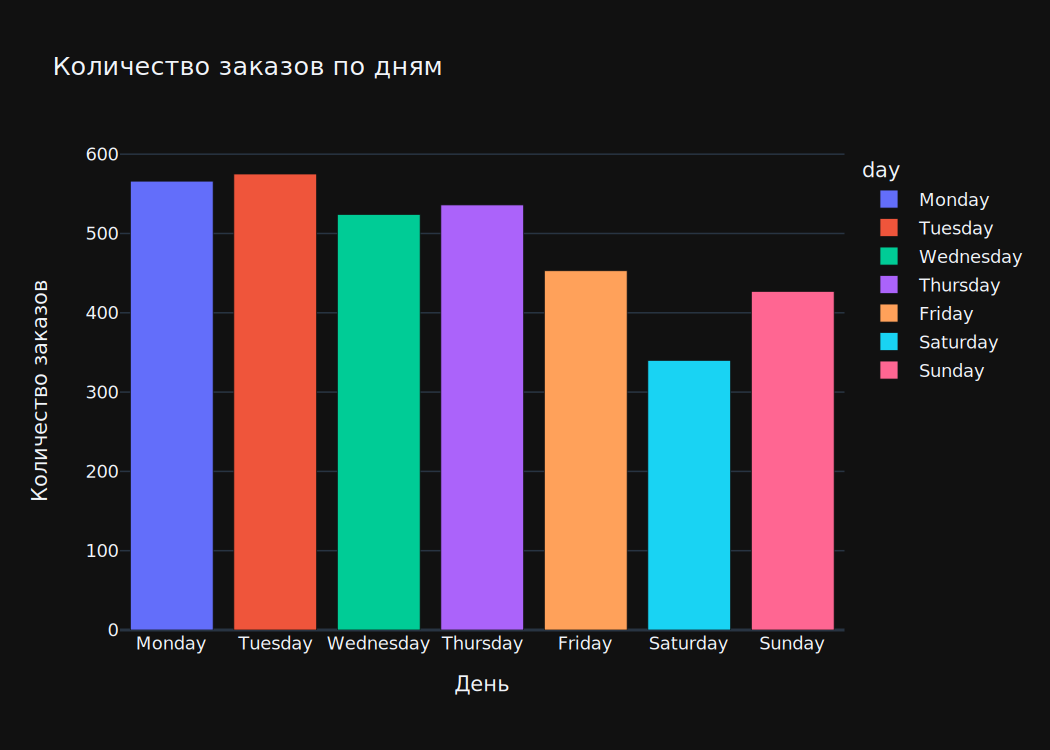

По графику понятно, что в будние дни заказов больше, с пятницы их число снижается, в субботу мы видим самый низкий уровень.


In [23]:
fig.update_layout(xaxis_title='День',
                  yaxis_title='Количество заказов')
fig.show()
print("По графику понятно, что в будние дни заказов больше, с пятницы их число снижается, в субботу мы видим самый низкий уровень.")

In [24]:
hour_orders = data.pivot_table(index='hour',
                               values='order_id',
                               aggfunc='nunique').reset_index().sort_values('hour')

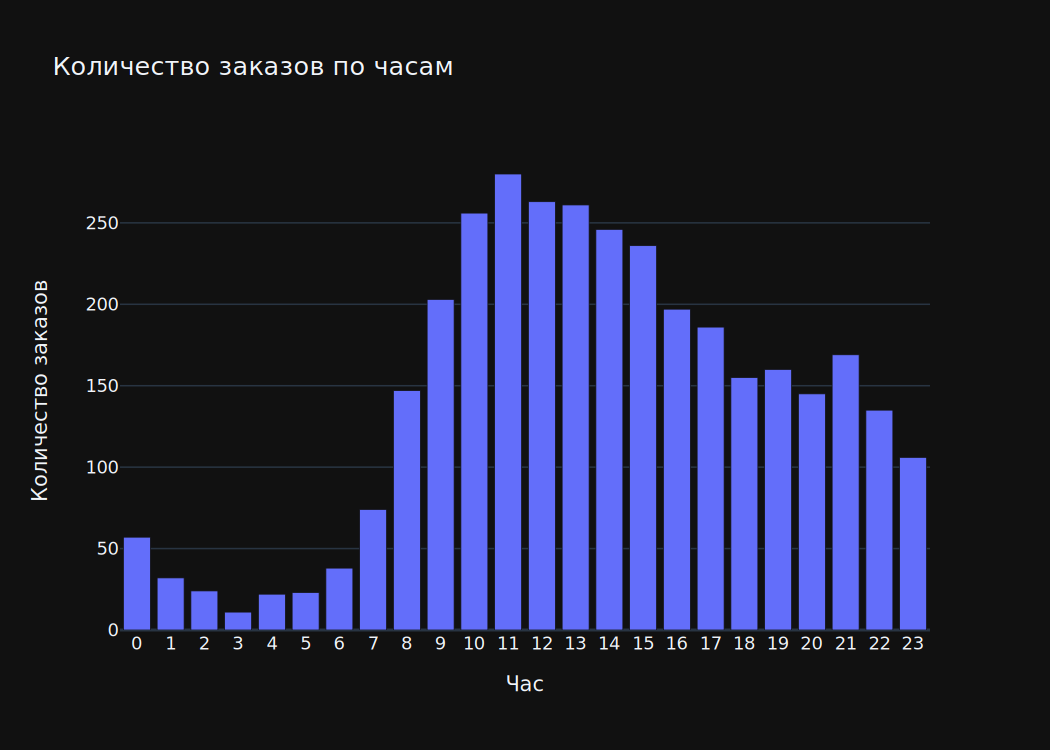

In [25]:
fig = px.bar(hour_orders,
             x='hour',
             y='order_id',
             title='Количество заказов по часам',
             template='plotly_dark')
fig.update_layout(xaxis_title='Час',
                  yaxis_title='Количество заказов',
                  xaxis=dict(
                      tickmode='array',
                      tickvals=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
                  )
fig.show()

Меньше всего заказов в 3 часа ночи. Показатель медленно растет до 7 утра, а в 8 резко увеличивается в 2 раза до 150. Пик количества заказов приходится на 11 часов дня - 280 заказов, после он медленно снижается, в 16 часов опускается ниже 200. В 21 час небольшой скачок до 180 и к 23 часу показатель достигает 100. 

### Основной и дополнительный ассортимент
Начнем АВС-анализ. Для этого сначала нам нужно определить процент от выручки, который приносит каждая позиция.
Нужно разделить выручку по товару на общую выручку компании и умножить на 100%.")
считаем процент для каждого заказа от общей выручки

In [26]:
data['percent_of_revenue'] = (data['revenue'] / data['revenue'].sum()) * 100

Распределяем все товары по убыванию этого процента

In [27]:
percent_of_revenue_df = data.pivot_table(index='product',
                                         values='percent_of_revenue',
                                         aggfunc='sum').sort_values(by='percent_of_revenue',
                                                                    ascending=False).reset_index()
print(percent_of_revenue_df.head())

                                             product  percent_of_revenue
0         сумка-тележка 2-х колесная gimi argo синяя            1.437452
1  сумка-тележка хозяйственная andersen scala sho...            0.799788
2                     сушилка meliconi stendy junior            0.797649
3  мусорный контейнер hailo bigbin swing 45 0845-...            0.785957
4  урна уличная гео, hobbyka/хоббика, 59*37,5см, ...            0.694985


Рассчитываем по каждой строке долю выручки нарастающим итогом, начиная с тех товаров, которые дают самый существенный вклад.

In [28]:
percent_of_revenue_df['cumulative_percent'] = percent_of_revenue_df['percent_of_revenue'].cumsum()
print(percent_of_revenue_df.head())

                                             product  percent_of_revenue  \
0         сумка-тележка 2-х колесная gimi argo синяя            1.437452   
1  сумка-тележка хозяйственная andersen scala sho...            0.799788   
2                     сушилка meliconi stendy junior            0.797649   
3  мусорный контейнер hailo bigbin swing 45 0845-...            0.785957   
4  урна уличная гео, hobbyka/хоббика, 59*37,5см, ...            0.694985   

   cumulative_percent  
0            1.437452  
1            2.237240  
2            3.034889  
3            3.820846  
4            4.515831  


Разбиваем все товары на три группы:
А — дают 80% выручки;
В — формируют 15% выручки;
С — дополняют оставшиеся 5%.

In [29]:
def abc_group(percent):
    if 0 < percent <= 80:
        return 'A'
    elif 80 < percent < 95:
        return 'B'
    else:
        return 'C'

In [30]:
percent_of_revenue_df['revenue_group'] = percent_of_revenue_df['cumulative_percent'].apply(abc_group)
print(percent_of_revenue_df.head())

                                             product  percent_of_revenue  \
0         сумка-тележка 2-х колесная gimi argo синяя            1.437452   
1  сумка-тележка хозяйственная andersen scala sho...            0.799788   
2                     сушилка meliconi stendy junior            0.797649   
3  мусорный контейнер hailo bigbin swing 45 0845-...            0.785957   
4  урна уличная гео, hobbyka/хоббика, 59*37,5см, ...            0.694985   

   cumulative_percent revenue_group  
0            1.437452             A  
1            2.237240             A  
2            3.034889             A  
3            3.820846             A  
4            4.515831             A  


Теперь то же самое делаем по отношению к количеству проданного товара

In [31]:
quantity_products_df = data.pivot_table(index='product',
                                        values='quantity',
                                        aggfunc='sum').sort_values(by='quantity', ascending=False).reset_index()

In [32]:
quantity_products_df.columns = ['product', 'quantity']
quantity_products_df['perc_of_sales'] = quantity_products_df['quantity'] / quantity_products_df['quantity'].sum() * 100
quantity_products_df['quantity_cum_percent'] = quantity_products_df['perc_of_sales'].cumsum()
quantity_products_df['quantity_group'] = quantity_products_df['quantity_cum_percent'].apply(abc_group)
print(quantity_products_df.head())

                                             product  quantity  perc_of_sales  \
0  пеларгония розебудная red pandora укорененный ...        80       0.933162   
1  пеларгония зональная диам. 12 см сиреневый пол...        64       0.746530   
2  пеларгония зональная диам. 12 см красная махровая        63       0.734865   
3  пеларгония розебудная prins nikolai укорененны...        61       0.711536   
4  цветок искусственный гвоздика пластиковая один...        51       0.594891   

   quantity_cum_percent quantity_group  
0              0.933162              A  
1              1.679692              A  
2              2.414557              A  
3              3.126094              A  
4              3.720984              A  


Объединяем таблицы, чтобы получить категории для каждого продукта и разделить его дальше на основной и дополнительный

In [33]:
merge_groups_df = percent_of_revenue_df.merge(quantity_products_df,
                                              on='product',
                                              how='left').sort_values(['revenue_group', 'quantity_group'])

In [34]:
print(merge_groups_df[['revenue_group', 'quantity_group']].head())

  revenue_group quantity_group
0             A              A
1             A              A
2             A              A
3             A              A
4             A              A


In [35]:
# функция для определения товара в группу основного или дополнительного
def assortment_group(groups):
    if groups['revenue_group'] != 'C' and groups['quantity_group'] != 'C':
        return "основной"
    else:
        return "дополнительный"

In [36]:
merge_groups_df['assort_group'] = merge_groups_df.apply(assortment_group, axis=1)
print(merge_groups_df[['revenue_group', 'quantity_group', 'assort_group']].head())

  revenue_group quantity_group assort_group
0             A              A     основной
1             A              A     основной
2             A              A     основной
3             A              A     основной
4             A              A     основной


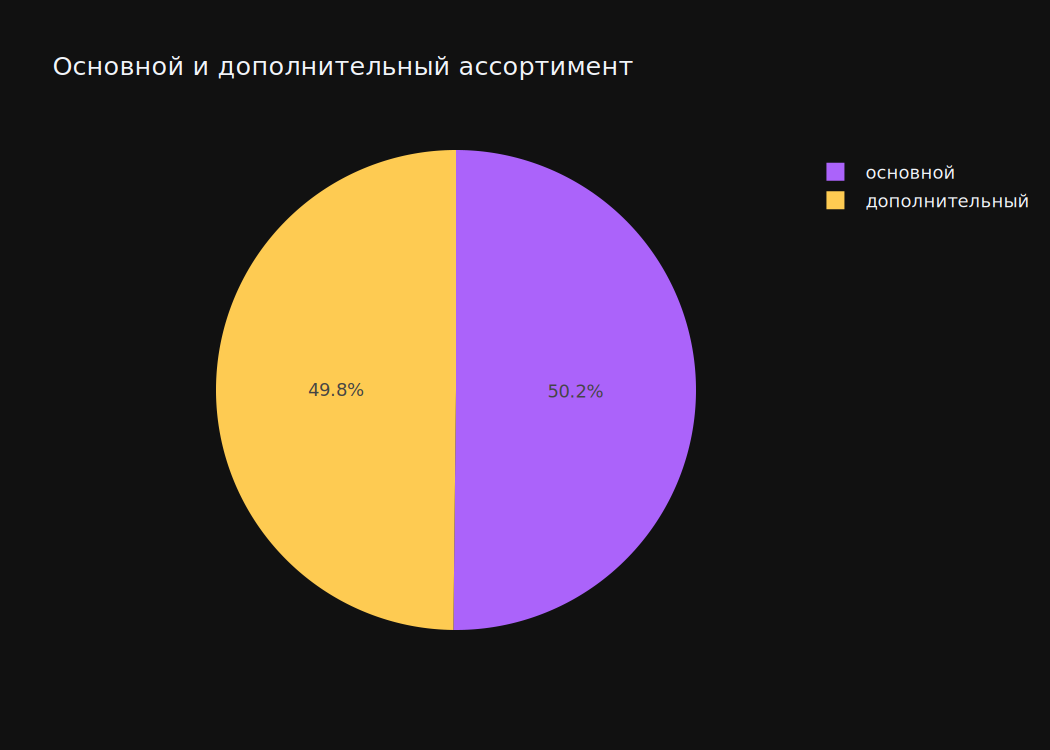

In [37]:
assort_df = merge_groups_df['assort_group'].value_counts().reset_index()
assort_df.columns = ('group', 'count')

# круговая диаграмма с долями основного и дополнительного товара
groups_pie = px.pie(assort_df,
                    values='count',
                    names='group',
                    title='Основной и дополнительный ассортимент',
                    template='plotly_dark',
                    color_discrete_sequence=['#AB63FA', '#FECB52']
                    )
groups_pie.show()

Основного ассортимента - 49.8%, дополнительного - 50.2%

In [38]:
# добавим к общему датасету столбец с группой товара
data_merge_assort_group = data.merge(merge_groups_df[['product', 'assort_group']], on='product', how='left')

In [39]:
# создаем таблицу и график количества товаров каждой группы по дням и месяцам
day_assort_group = data_merge_assort_group.pivot_table(index='day',
                                                       columns='assort_group',
                                                       values='product',
                                                       aggfunc='count').reset_index()

In [40]:
day_assort_group.columns = ('day', 'additional_product', 'basic_product')
day_assort_group['day'] = pd.Categorical(day_assort_group['day'],
                                         categories=days,
                                         ordered=True)
day_assort_group = day_assort_group.sort_values(by='day')
print(day_assort_group.head())

         day  additional_product  basic_product
1     Monday                 322            649
5    Tuesday                 257            609
6  Wednesday                 278            559
4   Thursday                 212            650
0     Friday                 208            485


In [41]:
fig = go.Figure(data=[
    go.Bar(name='дополнительный',
           x=day_assort_group['day'],
           y=day_assort_group['additional_product']),
    go.Bar(name='основной',
           x=day_assort_group['day'],
           y=day_assort_group['basic_product'])
])

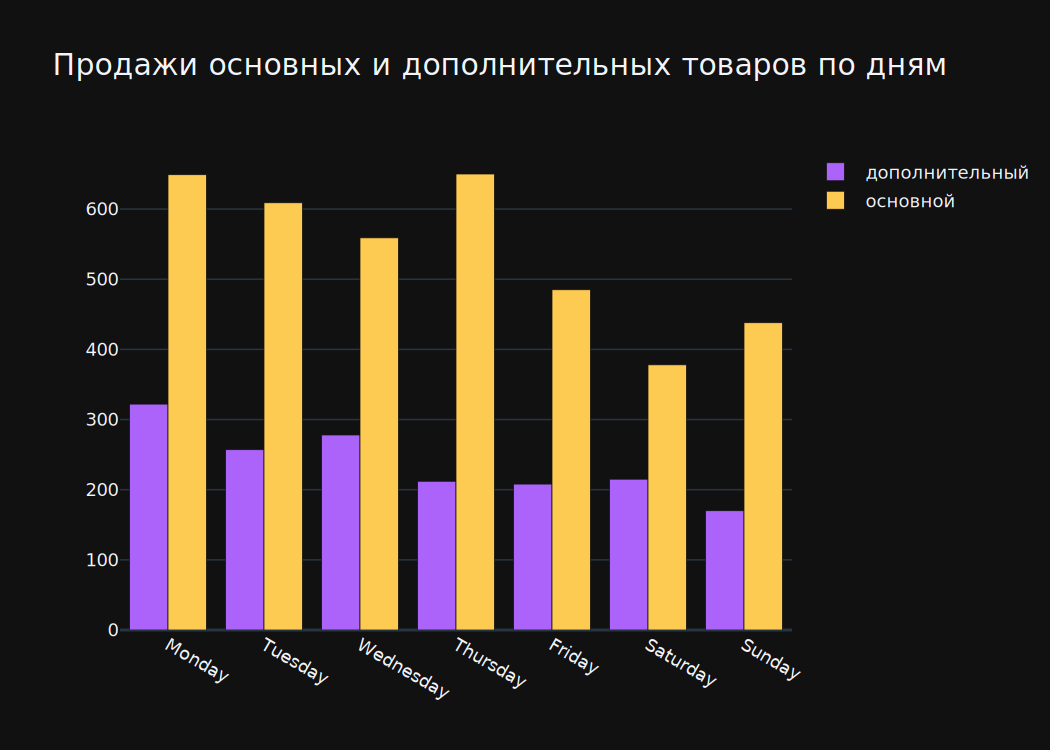

In [42]:
fig.update_layout(title_text='Продажи основных и дополнительных товаров по дням',
                  title_font_size=20,
                  barmode='group',
                  template="plotly_dark",
                  colorway=['#AB63FA', '#FECB52']
                  )
fig.show()

Наибольшая разница между продажами основного и дополнительного ассортимента в четверг - более 400 единиц. В этот день вырос показатель основного ассортимента, а продажи дополнительного снизились по сравнению с началом недели. Наименьшая разница в субооту - около 160. С понедельника по среду наблюдается плавный спад в продажах оснвного товара, который продолжается до субботы. Больше всего дополнительного товара продажется в понедельник - более 300 единиц. В течение недели показатель снижается и в воскресенье этих товаров продается меньше всего. 

In [43]:
month_assort_group = data_merge_assort_group.pivot_table(index=['year', 'month'],
                                                         columns='assort_group',
                                                         values='product',
                                                         aggfunc='count').reset_index()

In [44]:
month_assort_group.columns = ('year', 'month', 'additional_product', 'basic_product')
month_assort_group['month'] = pd.Categorical(month_assort_group['month'],
                                             categories=months,
                                             ordered=True)
month_assort_group = month_assort_group.sort_values(by=['year', 'month'])
print(month_assort_group.head())

   year     month  additional_product  basic_product
2  2018   October                 152            314
1  2018  November                 156            264
0  2018  December                  83            214
7  2019   January                  31            146
6  2019  February                  64            284


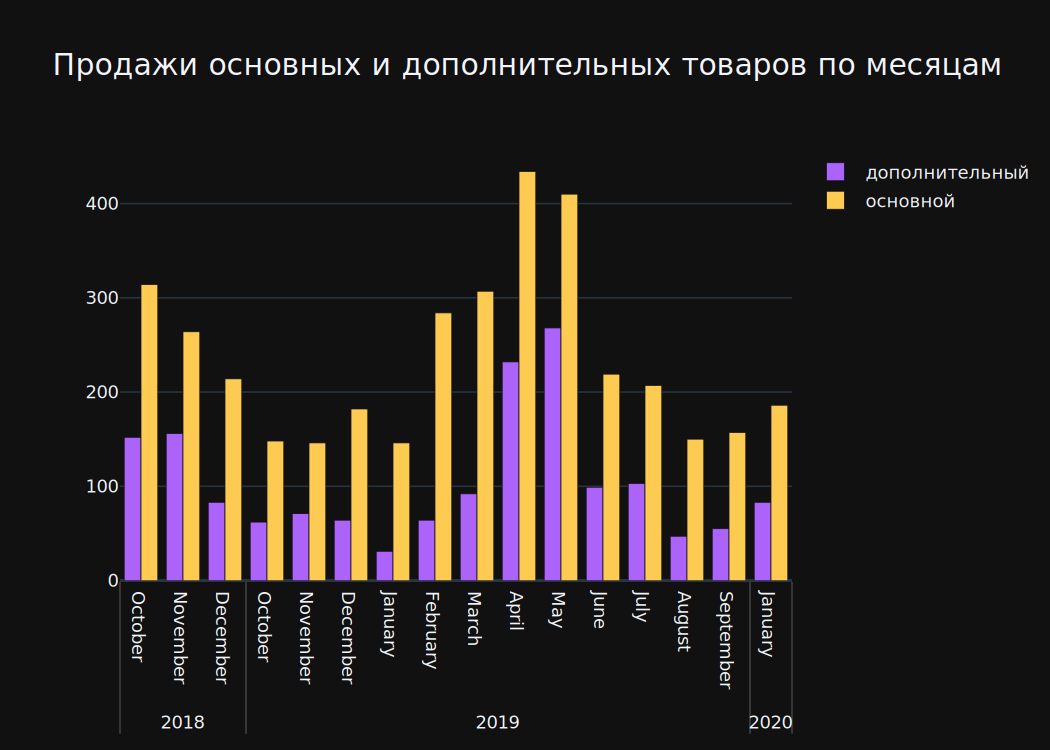

In [45]:
fig = go.Figure(data=[
    go.Bar(name='дополнительный',
           x=[month_assort_group['year'], month_assort_group['month']],
           y=month_assort_group['additional_product']),
    go.Bar(name='основной',
           x=[month_assort_group['year'], month_assort_group['month']],
           y=month_assort_group['basic_product'])
])
fig.update_layout(title_text='Продажи основных и дополнительных товаров по месяцам',
                  title_font_size=20,
                  barmode='group',
                  template="plotly_dark",
                  colorway=['#AB63FA', '#FECB52']
                  )

fig.show()

На этом графике мы видим, что октябрь и ноябрь 2019 сильно отличаются от показателей год назад. Самый большой разрыв в продажах основных и дополнительных товаров был в фефрале 2019 - 220 штук, а самый маленький в ноябре 2019 - 75 товаров. В целом динамика продаж такаяже, как на графике без разделения на основной и дополнительный ассортимент: рост продаж к апрелю, всплеск, затем спад. 

## Разделение товара на категории

нужно разделить товары на категории
сначала приведем в более удобную форму названия товара, для этого применим регулярные выражения,
лемматизацию и подсчет каждого слова

In [46]:
wnl = WordNetLemmatizer()
product_names = data['product'].unique()

In [47]:
product_names = ' '.join(product_names)
product_names = re.sub(r'\s+[а-яА-Я]\s+', ' ', product_names)
product_names = re.sub(r'\s+[a-zA-Z]\s+', ' ', product_names)
product_names = re.sub(r'[a-zA-Z]', ' ', product_names)
product_names = re.sub(r'\s+', ' ', product_names, flags=re.I)
product_names = re.sub(r'[^\w\s]+|[\d]+', r'', product_names)
product_names = product_names.lower()
product_names = product_names.split()
product_names = [wnl.lemmatize(word) for word in product_names]
print(Counter(product_names))

Counter({'см': 1085, 'для': 537, 'х': 362, 'рассада': 221, 'шт': 212, 'сорт': 171, 'белья': 140, 'сушилка': 116, 'объем': 114, 'кассете': 103, 'по': 101, 'диам': 95, 'томата': 93, 'помидор': 93, 'горшке': 88, 'пеларгония': 86, 'сумкатележка': 84, 'из': 81, 'доска': 75, 'хозяйственная': 75, 'мл': 74, 'ника': 74, 'белая': 74, 'гладильная': 73, 'коврик': 72, 'ванной': 72, 'кухни': 71, 'зелени': 68, 'муляж': 68, 'кассета': 67, 'среднеспелый': 67, 'красный': 61, 'зональная': 61, 'хх': 60, 'роза': 59, 'чехол': 58, 'белый': 54, 'искусственный': 54, 'цветок': 53, 'цветов': 53, 'штора': 52, 'комнаты': 52, 'на': 50, 'индетерминантный': 50, 'доски': 49, 'россия': 49, 'махровая': 49, 'петуния': 47, 'красная': 46, 'набор': 45, 'пластмассовый': 43, 'полиуретан': 41, 'однолетних': 41, 'гладильной': 40, 'хлопок': 39, 'придверный': 39, 'черный': 39, 'раннеспелый': 38, 'садовая': 36, 'детерминантный': 36, 'таз': 35, 'цвет': 35, 'синяя': 35, 'пластиковая': 33, 'оранжевый': 33, 'мм': 33, 'крышкой': 33, 'р

Все слова нам не понадобятся, удаляем почти все прилагательные за исключением тех, которые часто встречаются и ярко характеризуют товар.
Словарь был составлен вручную

In [48]:
category_dict = {'товары для дома': ['сушилка', "гладильная", 'хозяйственная', 'коврик', 'чехол', 'штора', 'придверный', 'таз', 'вешалка', 'горшок',
                                     'потолочная', 'напольная', 'кашпо', 'контейнер', 'щетка', 'полки', 'ванны', 'полотенце', 'швабра',
                                     'вешалок', 'карниз', 'крючок', 'ёрш', 'ковер', 'жаккард', 'ванну', 'ручка', 'фужеров', 'кофр',
                                     'лоток', 'весы', 'подставка', 'термокружка', 'термос', 'свч', 'спрей', 'щетка-сметка',
                                     'плед', 'простыня', 'крышка', "пылесос", 'мыло', 'ящик', 'сиденье', 'покрывало', 'этажерка', 'мешок',
                                     'сетка', 'плечики', 'веник', 'вешалка-плечики', 'вешалка-стойка', 'вешалки',
                                     'крючка', 'бокалов', 'стаканов', 'скребок', 'наволочки', 'напольные', 'одеяло', 'вантуз',
                                     'совок', 'ведра', 'полка', 'ткань', 'прищепки', 'ерш', 'подкладка', 'дозатор', 'подушка',
                                     'крепеж', 'короб', 'утюг', 'халат', 'обувная', 'термометр', 'комод', 'гель', 'пододеяльник',
                                     'штанга', 'пепельница', 'стеллаж', 'насадки', 'биопорошок', 'светильник', 'ламп', 'лампа',
                                     'щетка-утюжок', 'ковёр', 'наматрасник', 'салфетница', 'ролик', 'сменный блок', 'ножницы',
                                     'ополаскиватель', 'мыльница', 'фоторамка', 'кондиционер', 'простынь', 'салфетки', 'мыло-скраб',
                                     'концентрат', 'наматрацник', 'наволочка', 'валик', 'тряпки', 'обувница', 'антинакипин',
                                     'сотейник', 'ванна', 'корзинка', 'ваза', 'шприц', 'насадками', 'защелка', 'отбеливатель',
                                     'сахарница', 'пьезозажигалка', 'щётка', 'гжель', 'уголок', 'тряпка', 'белье', 'шпингалет', 'муляж', 'стол'],
                 'товары для кухни': ['кухни', 'тарелка', 'скатерть', 'салатник', 'чайник', 'кружка', 'нож', 'десертная', 'обеденная',
                                      'ложка', 'посуды', 'салфетка', 'сковорода', 'перчатки', 'вилка', 'стакан', 'выпечки', 'кастрюля',
                                      'разделочная', 'миксер', 'подрукавник', 'терка', 'миска', 'хлебница', 'форма', 'толкушка',
                                      'рыбочистка', 'ковш', 'термостакан', 'соковарка', 'противень', 'минисковорода', 'ножеточка',
                                      'масленка', 'овощеварка', 'овощечистка', 'измельчитель', 'мантоварка', 'картофелемялка',
                                      'дуршлаг', 'мясорубки', 'мясорубка', 'электроштопор', 'бульонница', 'блюдце', 'орехоколка',
                                      'скалка', 'венчик', 'сито', 'тортница', 'блюдо', 'соковыжималка', 'половник', 'кипятильник'],
                 'товары для дачи и ремонтных работ': ['садовая', 'стремянка', 'черенок', 'ведро', 'лестница-стремянка',
                                                       'тележки', 'корыто', 'кисточка', 'камнеломка', 'шпагат', 'пена', 'бензин',
                                                       'камешки', 'пеперомия', 'дрова', 'сверло', 'веревка', 'лестница'],
                 'еда и напитки': ['сильвердроп', 'капучино', 'брауни', 'виски', 'латте', 'скелетон', 'лейс', 'вино', 'зефир',
                                   'булка', 'бренди', 'тоффи', 'тутти-фрутти', 'суфле', "вода"],
                 'растения': ['рассада', 'томата', 'пеларгония', 'роза', 'петуния', 'однолетних', 'герань', 'мята', 'белокачанная',
                              'калибрахоа', 'однолетнее', 'цикламен', 'флокс', 'примула', 'базилик', 'тимьян',
                              'вербена', 'фиалка', 'пуансеттия', 'гвоздика', 'бегония', 'бакопа', 'петрушка',
                              'розмарин', 'бальзамин', 'космея', 'хризантема', 'антуриум', 'спирелла',
                              'тюльпан', 'лаванда', 'виола', 'сальвия', 'кабачка', 'эвкалипт', 'азалия', 'андрианум',
                              'ель', 'комнатный', 'кольраби', 'гербера', 'кокоса', 'ромашка', 'горох', 'ротанг', 'алиссум',
                              'оффициналис', 'декабрист', 'лобелия', 'индика', 'гортензия', 'кордана', 'акаулис', 'дендробиум',
                              'львиный зев', 'коника', 'цинния', 'пиперита', 'астра', 'патиссон', 'зверобой', 'эхеверия', 'верона',
                              'кориандр', 'иссоп', 'лекарственный', 'аспарагус', 'бэлльюниор', 'душица', 'мелисса', 'сорго',
                              'мак', 'нарцисс', 'каланхое', 'каландива', 'стэма', 'настурция', 'воларэ', 'календула',
                              'фаленопсис', 'ландыш', 'подснежник', 'ауреум', 'земляника', 'калла', 'газания',
                              'цитрата', 'колокольчик', 'остеоспермум', 'семена', 'саженец', 'саженцы', 'сельдерей',
                              'тагетис', 'портулак', 'целозия', 'шеффлера', 'тимьян-чабрец', 'гунни', 'калатея',
                              'глоксиния', 'мирт', 'шалфея', 'сантолина', 'афеляндра', 'скуарроса', 'лаванды', 'розмарина',
                              'тимьяна', 'орегано', 'морковь', 'розебад', 'крокус', 'ирис', 'крассула', 'мимоза', 'калитва',
                              'кореопсис', 'лапчатка', 'цинерария', 'диффенбахия', 'аптения', 'арлет', 'сциндапсус', 'плющ',
                              'эмпилабль', 'эхинокактус', 'ориганум', 'луковицы', 'незабудка', 'седум', 'георгин', 'шаймет',
                              'касади', 'анемона', 'зенгана', 'циния', 'гардения', 'колеус', 'цинерания', 'фатсия', 'кабачок',
                              'монарда', 'вариегата', 'осина', 'сосна', 'лантана', 'салат', 'рукола', 'радермахера',
                              'хризолидокарпус', 'лутесценс', 'циперус', 'зумула', 'лузеана', 'юкка', 'суккулент', 'дампьер',
                              'кумган', 'адиантум', 'кампанула', 'мейера', 'розебуд', 'спиралис', 'артемизия', 'полынь',
                              'калоцефалус', 'каллуна', 'капсикум', 'бархатцы', 'лобулярия', 'годеция', 'друммонда', 'эшшольция',
                              'подсолнечник', 'пуансетия', 'кипарисовик', 'элвуди', 'скиммия', 'рубелла', 'спренжери', 'фиттония',
                              'куэна', 'сирень', 'гипсофила', 'укроп', 'нефролепис', 'гиацинт', 'ранункулус', 'цитриодорус',
                              'вербейник', 'травянка', 'котовник', 'эхинацея', 'ясколка', 'папоротник', 'страусник', 'платикодон',
                              'энотера', 'цитрофортунелла', 'василек', 'синнингия', 'орхидея', 'фиалки', 'тускан', 'хамаекипарисус',
                              'цимбопогон', 'шпинат', 'джалпа', 'голубика', 'мускари', 'пиретрум', 'гелихризум', 'агератум',
                              'муррайя', 'дихондра', 'калибрахоя', 'маттиола', 'джункус', 'драцена', 'эдельвейс', 'хиларис',
                              'хоста', 'грандесса', 'лампион', 'гайлардия', 'нивянник', 'рудбекия', 'бузульник', 'физостегия',
                              'бадан', 'буддлея', 'вейера', 'валериана', 'кардиола', 'змееголовник', 'шалфей', 'хамедорея',
                              'гвинея', 'замиокулькас', 'чурленис', 'плектрантус', 'амариллис', 'пахира', 'традесканция', 'комнатное растение',
                              'комнатное', 'комнатный', 'комнатная', 'растение'],
                 }

In [49]:
# функция для категоризации
def categorize_product(product):
    for category, items_of_list in category_dict.items():
        for item in items_of_list:
            if item in product:
                return category
    return category

In [50]:
data_merge_assort_group['product_category'] = data_merge_assort_group['product'].apply(categorize_product)

In [51]:
# параметры, чтобы увидеть таблицу со значениями для каждой категории полностью
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
category_data = data_merge_assort_group.groupby('product_category').agg({'customer_id': 'nunique',
                                                                         'quantity': 'sum',
                                                                         'order_id': 'count',
                                                                         'product': 'nunique',
                                                                         'price': 'mean',
                                                                         'revenue': 'sum'}).round(2)
print(category_data)
print(category_data['product'].sum())

                                   customer_id  quantity  order_id  product   price  revenue
product_category                                                                            
еда и напитки                               22        34        22       13  173.50     5426
растения                                  1118      3933      2508      956  289.60   899121
товары для дачи и ремонтных работ          284       600       468      104  333.29   174157
товары для дома                           1257      3042      1871      948  993.75  2167213
товары для кухни                           328       964       561      279  320.66   260636
2300


Больше всех выручки приносят товары для дома - более 2 млн. На втором месте растения - почти 900 тысяч, хотя их было продано больше, чем товаров для дома, средняя цена растений меньше в 3 раза. А вот у товаров для кухни и товаров для дачи и ремонтных работ средняя цена почти одинаковая, но второй категории было продано на 1/3 меньше единиц. Самой непопулярной категорией является еда и напитки.  

In [52]:
# таблица и график, показывающие, сколько единиц каждой категории было продано в разные месяцы разных лет
month_category_quantity = data_merge_assort_group.pivot_table(index=['year', 'month'],
                                                              columns='product_category',
                                                              values='quantity',
                                                              aggfunc='sum').reset_index()
months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
month_category_quantity['month'] = pd.Categorical(month_category_quantity['month'],
                                                  categories=months,
                                                  ordered=True)
month_category_quantity = month_category_quantity.sort_values(by=['year', 'month']).reset_index(drop=True)
print(month_category_quantity.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   year                               16 non-null     int32   
 1   month                              16 non-null     category
 2   еда и напитки                      11 non-null     float64 
 3   растения                           16 non-null     float64 
 4   товары для дачи и ремонтных работ  16 non-null     float64 
 5   товары для дома                    16 non-null     float64 
 6   товары для кухни                   16 non-null     float64 
dtypes: category(1), float64(5), int32(1)
memory usage: 1.2 KB
None


In [53]:
month_category_quantity.loc[:, ['еда и напитки']] = month_category_quantity.loc[:, ['еда и напитки']].fillna('')
print(month_category_quantity)

product_category  year      month еда и напитки  растения  товары для дачи и ремонтных работ  товары для дома  товары для кухни
0                 2018    October                   264.0                               13.0            441.0              82.0
1                 2018   November           1.0     180.0                                6.0            351.0             172.0
2                 2018   December                   166.0                               10.0            249.0              91.0
3                 2019    January           3.0     116.0                                7.0            153.0              45.0
4                 2019   February           1.0     263.0                               81.0            184.0              66.0
5                 2019      March           2.0     358.0                               94.0            160.0              80.0
6                 2019      April           7.0     778.0                              117.0            

Построим график по таблице выше.

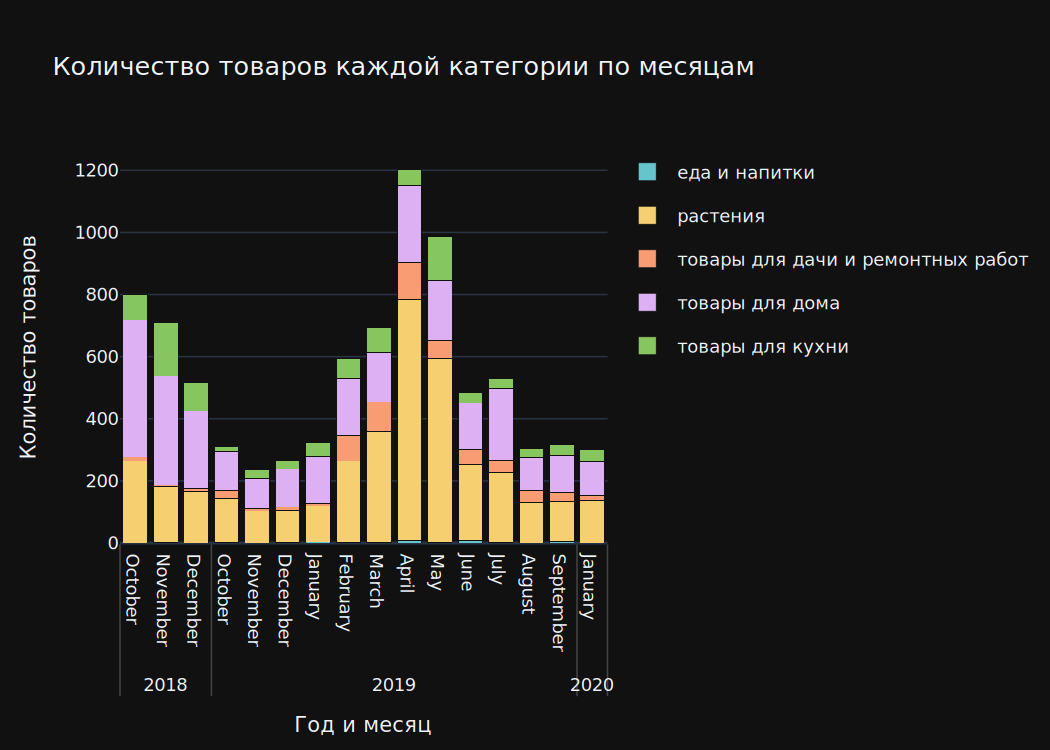

In [54]:
columns = month_category_quantity.columns[2:]
palette = cycle(px.colors.qualitative.Pastel)
colors = {c: next(palette) for c in columns}
fig = make_subplots(rows=1, cols=1)
for cols in columns:
    fig.add_trace(go.Bar(x=[month_category_quantity['year'], month_category_quantity['month']],
                         y=month_category_quantity[cols],
                         name=cols,
                         legendgroup=cols,
                         marker_color=colors[cols],
                         showlegend=True), row=1, col=1)
    
fig.update_layout(title_text='Количество товаров каждой категории по месяцам',
                  xaxis_title='Год и месяц',
                  yaxis_title='Количество товаров',
                  barmode='stack',
                  template='plotly_dark'
                  )
fig.show()

С февраля по июль мы видим возрастание и спад популярности растений и товаров для дачи и ремонтных работ, ее пик приходится на апрель-май, также растения становятся заметны в ноябре, декабре 2019 года и январе 2020 при том, что год назад мы почти не видим в эти месяцы данную категорию. В холодное время года могут покупать комнатные растения, поэтому в данные месяцы стоит расширить их ассортимент и посмотреть, как быстро заканчивается товар, возможно, его количество следует увеличить. Товары для дома востребованы большую часть года как и товары для кухни, но меньше всего их покупают в ноябре, апреле и мае 2019 года.

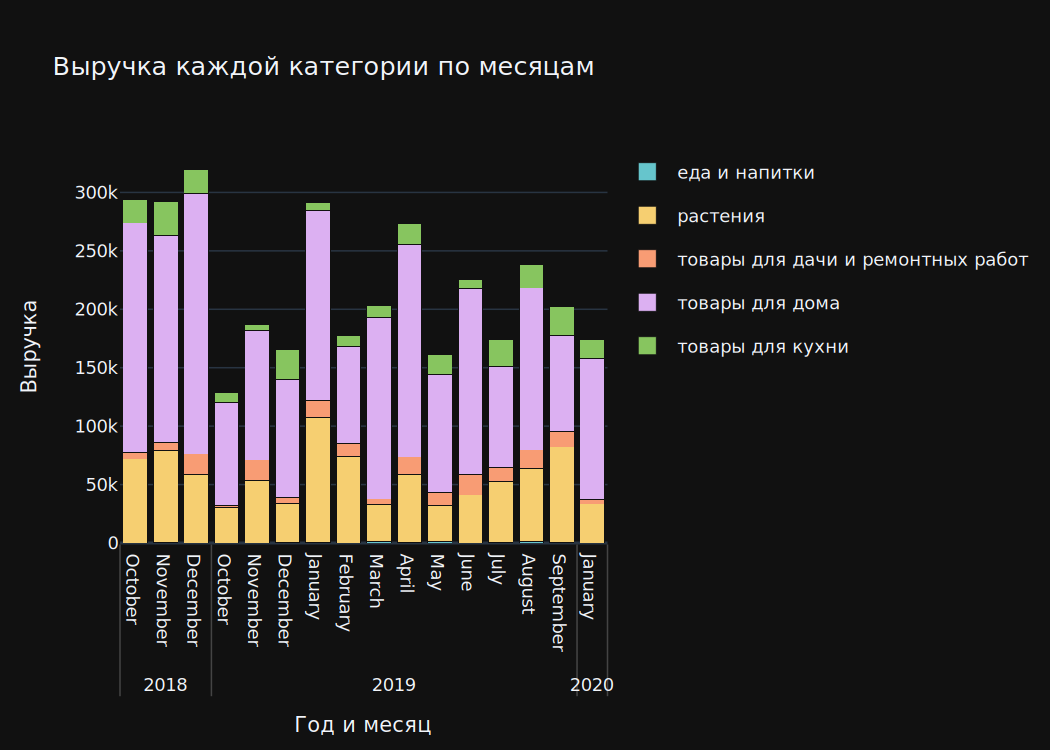

In [55]:
# таблица и график, показывающие, сколько единиц каждой категории было продано в разные месяцы разных лет
month_category_revenue = data_merge_assort_group.pivot_table(index=['year', 'month'],
                                                              columns='product_category',
                                                              values='revenue',
                                                              aggfunc='sum').reset_index()
months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
month_category_revenue['month'] = pd.Categorical(month_category_quantity['month'],
                                                  categories=months,
                                                  ordered=True)
month_category_revenue = month_category_revenue.sort_values(by=['year', 'month']).reset_index(drop=True)
month_category_revenue.loc[:, ['еда и напитки']] = month_category_revenue.loc[:, ['еда и напитки']].fillna('')

columns = month_category_revenue.columns[2:]
palette = cycle(px.colors.qualitative.Pastel)
colors = {c: next(palette) for c in columns}
fig = make_subplots(rows=1, cols=1)
for cols in columns:
    fig.add_trace(go.Bar(x=[month_category_revenue['year'], month_category_revenue['month']],
                         y=month_category_revenue[cols],
                         name=cols,
                         legendgroup=cols,
                         marker_color=colors[cols],
                         showlegend=True), row=1, col=1)
    
fig.update_layout(title_text='Выручка каждой категории по месяцам',
                  xaxis_title='Год и месяц',
                  yaxis_title='Выручка',
                  barmode='stack',
                  template='plotly_dark'
                  )
fig.show()

Мы видим, что товароы для дома каждый месяц приносят больше всего выручки, только в сентябре 2019 они почти сравнялись с растениями. На других графиках апрель и май лидировали по количеству проданного товара, но оказывается хоть в октябре, ноябре и декабре 2018 было продано меньше единиц, эти месяцы принесли больше выручки. То же самое относится и к январю 2019 года. Также заметна сильная разница между октябрем, ноябрем и декабрем 2019 и 2018 годов. В 2019 в каждом месяцев выручки было почти 2 раза меньше, чем год назад.

***Вывод по разделу "Категоризацая данных"***

Чтобы привести названия товара в удобный вид и категоризировать их в последствие, мы использовали регулярные выражения и лемматизацию. Словарь с категориями был составлен вручную. После добавления столбеца с ними в общую таблицу мы сгруппировали данные по категориям и узнали, как много единиц товаров каждой из категорий было продано, сколько человек их купили и как много выручки принесли эти товары. 

Также мы построили два графика по количеству проданного товара каждой категории и выручке. 

## Проверка гипотез

Н0: среднее количество проданных дополнительных товаров в понедельник
 равно среднему количеству проданных дополнительных товаров в субботу.

Н1: среднее количество проданных дополнительных товаров в понедельник
неравно среднему количеству проданных дополнительных товаров в субботу.

In [56]:
# prevent SettingWithCopyWarning message from appearing
# pd.options.mode.chained_assignment = None

In [57]:
monday_additional_sales = data_merge_assort_group.query('day=="Monday" & assort_group=="дополнительный"')
saturday_additional_sales = data_merge_assort_group.query('day=="Saturday" & assort_group=="дополнительный"')

In [58]:
monday_additional_sales['date'] = monday_additional_sales['date'].dt.date
saturday_additional_sales['date'] = saturday_additional_sales['date'].dt.date

C:\Users\Polly\AppData\Local\Temp\ipykernel_13324\60429631.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Polly\AppData\Local\Temp\ipykernel_13324\60429631.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
monday_grouped_additional_sales = monday_additional_sales.groupby('date')['assort_group'].agg('count').reset_index()
monday_grouped_additional_sales.columns = ('day', 'count')

In [60]:
saturday_grouped_additional_sales = saturday_additional_sales.groupby('date')['assort_group'].agg('count').reset_index()
saturday_grouped_additional_sales.columns = ('day', 'count')

In [61]:
print(monday_grouped_additional_sales.head())

          day  count
0  2018-10-01      8
1  2018-10-08      4
2  2018-10-15      2
3  2018-10-22     12
4  2018-10-29      7


In [62]:
alpha = 0.05

result = st.ttest_ind(monday_grouped_additional_sales['count'],
                      saturday_grouped_additional_sales['count'])

print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается. Среднее количество проданных дополнительных товаров в понедельник неравно среднему количеству проданных дополнительных товаров во вторник.')
else:
    print('Мы не можем отвергнуть нулевую гипотезу. Среднее количество проданных дополнительных товаров в понедельник равно среднему количеству проданных дополнительных товаров во вторник.')

p-значение: 0.3860198951762496
Мы не можем отвергнуть нулевую гипотезу. Среднее количество проданных дополнительных товаров в понедельник равно среднему количеству проданных дополнительных товаров во вторник.


Н0: среднее количество проданных основных товаров в марте равно среднему количеству проданных основных товаров в августе.   
Н1: среднее количество проданных основных товаров в марте неравно среднему количеству проданных основных товаров в августе.

In [63]:
march_basic_sales = data_merge_assort_group.query('month=="March" & assort_group=="дополнительный"')
august_basic_sales = data_merge_assort_group.query('month=="August" & assort_group=="дополнительный"')

In [64]:
march_basic_sales['date'] = march_basic_sales['date'].dt.date
august_basic_sales['date'] = august_basic_sales['date'].dt.date

C:\Users\Polly\AppData\Local\Temp\ipykernel_13324\191774025.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Polly\AppData\Local\Temp\ipykernel_13324\191774025.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
march_grouped_basic_sales = march_basic_sales.groupby('date')['assort_group'].agg('count').reset_index()
march_grouped_basic_sales.columns = ('date', 'count')

In [66]:
august_grouped_basic_sales = august_basic_sales.groupby('date')['assort_group'].agg('count').reset_index()
august_grouped_basic_sales.columns = ('date', 'count')

In [67]:
print(march_grouped_basic_sales.head())

         date  count
0  2019-03-01      4
1  2019-03-02      1
2  2019-03-03      8
3  2019-03-04     12
4  2019-03-05      2


In [68]:
result = st.ttest_ind(march_grouped_basic_sales['count'], august_grouped_basic_sales['count'])

In [69]:
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается. Среднее количество проданных основных товаров в марте неравно среднему количеству проданных основных товаров в августе.')
else:
    print('Мы не можем отвергнуть нулевую гипотезу. Среднее количество проданных основных товаров в марте равно среднему количеству проданных основных товаров в августе.')

p-значение: 0.1595010826086022
Мы не можем отвергнуть нулевую гипотезу. Среднее количество проданных основных товаров в марте равно среднему количеству проданных основных товаров в августе.


Н0: средняя выручка заказов сделанных с 23 часов ночи до 11 часов утра равна средней выручке заказов, сделанных с 11 часов утра до 23 часов ночи

Н1: средняя выручка заказов сделанных с 23 часов ночи до 11 часов утра неравна средней выручке заказов, сделанных с 11 часов утра до 23 часов ночи

In [70]:
night_orders = data_merge_assort_group.query('hour<11 or hour==23')
day_orders = data_merge_assort_group.query('hour>=11 and hour!=23')

In [71]:
night_orders_money = night_orders.groupby('hour')['revenue'].agg('mean').reset_index().sort_values(by='hour')
day_orders_money = day_orders.groupby('hour')['revenue'].agg('mean').reset_index().sort_values(by='hour')
print(night_orders_money, day_orders_money)

    hour      revenue
0      0   700.164179
1      1   468.413793
2      2  1051.851852
3      3  1022.727273
4      4   677.500000
5      5   554.717949
6      6  1036.867925
7      7  1033.040816
8      8   556.325088
9      9   616.441176
10    10   627.057743
11    23   550.827338     hour     revenue
0     11  645.724832
1     12  732.036939
2     13  620.089686
3     14  539.494226
4     15  630.476965
5     16  550.456522
6     17  767.474916
7     18  860.061321
8     19  677.532520
9     20  633.230769
10    21  574.424242
11    22  593.050459


In [72]:
result = st.ttest_ind(day_orders_money['revenue'], night_orders_money['revenue'], alternative='greater')

In [73]:
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается. Средняя выручка заказов сделанных с 23 часов ночи до 11 часов утра неравна средней выручке заказов, сделанных с 11 часов утра до 23 часов ночи')
else:
    print('Мы не можем отвергнуть нулевую гипотезу. Средняя выручка заказов сделанных с 23 часов ночи до 11 часов утра равна средней выручке заказов, сделанных с 11 часов утра до 23 часов ночи')

p-значение: 0.8900810999656744
Мы не можем отвергнуть нулевую гипотезу. Средняя выручка заказов сделанных с 23 часов ночи до 11 часов утра равна средней выручке заказов, сделанных с 11 часов утра до 23 часов ночи


In [74]:
# Н0:средняя выручка товаров для кухни за месяц равна средней выручке товаров для дома.
# Н1:средняя выручка товаров для кухни за месяц больше средней выручки товаров для дома.
products_kitchen = data_merge_assort_group.query('product_category=="товары для кухни"')
products_home = data_merge_assort_group.query('product_category=="товары для дома"')

In [75]:
kitchen_mean_revenue = products_kitchen.pivot_table(index='month', values='revenue', aggfunc='mean').reset_index()

In [76]:
kitchen_mean_revenue['month'] = pd.Categorical(kitchen_mean_revenue['month'],
                                               categories=months,
                                               ordered=True)
kitchen_mean_revenue = kitchen_mean_revenue.sort_values(by='month').reset_index(drop=True)

In [77]:
home_mean_revenue = products_home.pivot_table(index='month', values='revenue', aggfunc='mean').reset_index()
home_mean_revenue['month'] = pd.Categorical(home_mean_revenue['month'],
                                            categories=months,
                                            ordered=True)
home_mean_revenue = home_mean_revenue.sort_values(by='month').reset_index(drop=True)

In [78]:
result = st.ttest_ind(kitchen_mean_revenue['revenue'], home_mean_revenue['revenue'], alternative='greater')

In [79]:
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается. Средняя выручка товаров для кухни за месяц больше средней выручки товаров для дома.')
else:
    print('Мы не можем отвергнуть нулевую гипотезу. Средняя выручка товаров для кухни за месяц равна средней выручки товаров для дома.')

p-значение: 0.9946480651334015
Мы не можем отвергнуть нулевую гипотезу. Средняя выручка товаров для кухни за месяц равна средней выручки товаров для дома.


Н0:средняя выручка товаров для кухни за месяц равна средней выручке товаров для дома.   
Н1:средняя выручка товаров для кухни за месяц меньше средней выручки товаров для дома.

In [80]:
result = st.ttest_ind(kitchen_mean_revenue['revenue'], home_mean_revenue['revenue'], alternative='less')

In [81]:
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергается. Средняя выручка товаров для кухни за месяц меньше средней выручки товаров для дома.')
else:
    print('Мы не можем отвергнуть нулевую гипотезу. Средняя выручка товаров для кухни за месяц равна средней выручки товаров для дома.')

p-значение: 0.005351934866598523
Нулевая гипотеза отвергается. Средняя выручка товаров для кухни за месяц меньше средней выручки товаров для дома.


## Общий вывод

Для анализа ассортимента мы получили данные, в которых хранилась информация за период с 1 октября 2018 года по 31 января 2020 года. В столбцах находились дата и час заказа, id покупателя, название купленного товара, id заказа, количество товара и цена. Для начала мы изменили тип данных в столбце с датой и часом, а также сделали цену целым числом. Изначально в датасете было 7474 строк. Явных дубликатов обнаружено не было, но в данных присутствовало множество неявных дубликатов, где отличалось только время заказа, возможно в таблицу заносился каждый шаг покупки. Поэтому мы оставили только последние записи. Также были обнаружены id заказов с несколькими покупателями, в этом случае мы удалили все подобные записи. В итоге в датасете осталось 5522 строк.

     Исследовательский анализ данных
Мы посмотрели самые популярные наименования. В ТОП 30 наиболее покупаемых товаров 18 раз входят различные сорта Пеларгонии. Узнали, в какие месяцы и дни заходит больше всего уникальных покупателей. Их числом выделяются октябрь, ноябрь, декабрь и январь. Их относительно высокие показатели можно объяснить задвоением в данных, данные за месяцы разных лет объединились в одном столбце диаграммы. Позже мы разберемся в этом подробнее. Зато четко видно, что в феврале, марте и апреле уникальных покупателей больше, чем в теплые месяцы.
Исходя из анализа тех месяцев, по которым есть данные виден всплеск покупательской активности в январе 2020: было сделано на 100 заказов больше, чем в январе 2019. Самое низкое значение в июне – 160 заказов. Кроме того, на графике видно, что в будние дни заказов больше, с пятницы их число снижается, в субботу мы видим самый низкий уровень.

     Анализ ассортимента
Для разделения ассортимента на основной и дополнительный в исследовании нами был использован АВС-анализ. С его помощью товары разделяются на группы:    
А — наиболее ценные, 20 % — ассортимента (номенклатура); 80 % — продаж
В — промежуточные, 30 % — ассортимента; 15 % — продаж
С — наименее ценные, 50 % — ассортимента; 5 % — продаж

В результате удалось выделить: основной ассортимент - 49.8%, дополнительный ассортимент - 50.2%. Продажи основных товаров чаще происходят по рабочим дням. Наибольшая разница между продажами основного и дополнительного ассортимента в четверг, в этот день вырос показатель основного ассортимента, а продажи дополнительного снизились по сравнению с началом недели. С понедельника по среду наблюдается плавный спад в продажах основного товара. Больше всего дополнительного товара продажется в понедельник. В течение недели показатель снижается и в воскресенье этих товаров продается меньше всего. Если смотреть по месяцам, то видно что октябрь и ноябрь 2019 сильно отличаются в отрицательную сторону от показателей год назад. Самый большой разрыв в продажах основных и дополнительных товаров был в фефрале 2019, а самый маленький в ноябре 2019. В целом динамика продаж такая же, как на графике без разделения на основной и дополнительный ассортимент: рост продаж к апрелю, всплеск, затем спад. 


         Категоризация данных

Также одной из наших задач было разделить все товары на категории и проанализировать их продажи. Для ее выполнения был создан словарь, где выделено 5 категорий: растения, товары для дома, товары для кухни, товары для дачи и ремонтных работ, еда и напитки.   
Больше всех выручки приносят товары для дома - более 2 млн. На втором месте растения - почти 900 тысяч, хотя их было продано больше, чем товаров для дома, средняя цена растений меньше в 3 раза. Товары для кухни и товары для дачи и ремонтных работ занимают средние позиции. Самой непопулярной категорией является еда и напитки.      
С февраля по июль происходили возрастание и спад популярности растений и товаров для дачи и ремонтных работ, ее пик приходится на апрель-май, также растения становятся заметны в ноябре, декабре 2019 года и январе 2020 при том, что год назад мы почти не видим в эти месяцы данную категорию - продавалось не более 15 штук в месяц. В холодное время года могут покупать комнатные растения, поэтому в данные месяцы стоит расширить их ассортимент и посмотреть, как быстро заканчивается товар, возможно, его количество следует увеличить. Товары для дома востребованы большую часть года, как и товары для кухни. 
Товары для дома каждый месяц приносят больше всего выручки, только в сентябре 2019 они почти сравнялись с растениями. Также из графика по выручке категорий мы узнали, что хоть в октябре, ноябре, декабре 2018 и январе 2019 года было продано меньше единиц, эти месяцы принесли больше выручки, чем апрель и май, которые выделялись на графиках большим количеством проданного товара. Сильно заметна разница между октябрем, ноябрем и декабрем 2019 и 2018 годов. В 2019 в каждом месяцев выручки было почти 2 раза меньше, чем год назад.  


        Статистический анализ данных

На основе изученной базы данных мы выдвинули несколько гипотез о равенстве средних с уровнем значимости 0.05:

**Н0: среднее количество проданных дополнительных товаров в понедельник равно среднему количеству проданных дополнительных товаров в субботу.   
Н1: среднее количество проданных дополнительных товаров в понедельник неравно среднему количеству проданных дополнительных товаров в субботу.**

Результат: p-значение: 0.2862525906690279. Мы не можем отвергнуть нулевую гипотезу. Среднее количество проданных дополнительных товаров в понедельник равно среднему количеству проданных дополнительных товаров в субботу.


**Н0: среднее количество проданных основных товаров в марте равно среднему количеству проданных основных товаров в августе.   
Н1: среднее количество проданных основных товаров в марте неравно среднему количеству проданных основных товаров в августе.**

Результат: p-значение: 0.15382645943917914. Мы не можем отвергнуть нулевую гипотезу. Среднее количество проданных основных товаров в марте равно среднему 
количеству проданных основных товаров в августе.


**Н0: средняя выручка заказов, сделанных с 23 часов ночи до 11 часов утра равна средней выручке заказов, сделанных с 11 часов утра до 23 часов ночи.   
Н1: средняя выручка заказов, сделанных с 23 часов ночи до 11 часов утра неравна средней выручке заказов, сделанных с 11 часов утра до 23 часов ночи.**   

Результат: p-значение: 0.37249019359654123. Мы не можем отвергнуть нулевую гипотезу. Средняя выручка заказов, сделанных с 23 часов ночи до 11 часов утра 
равна средней выручке за-казов, сделанных с 11 часов утра до 23 часов ночи.


**Н0: средняя выручка товаров для кухни за месяц равна средней выручке товаров для дома.   
Н1: средняя выручка товаров для кухни за месяц больше средней выручки товаров для дома.**   

Результат: p-значение: 0.9999999999999273. Мы не можем отвергнуть нулевую гипотезу. Средняя выручка товаров для кухни за месяц равна средней выручки товаров для дома.


**Н0: средняя выручка товаров для кухни за месяц равна средней выручке товаров для дома.   
Н1: средняя выручка товаров для кухни за месяц меньше средней выручки товаров для дома.**   

Результат: p-значение: 7.27139797943766e-14. Нулевая гипотеза отвергается. Средняя выручка товаров для кухни за месяц меньше средней выручки товаров для дома.